Решить задачу классификации изображений с помощью transfer learning. 

Данные для задачи необходимо взять для одной из задач из списка (на ваш выбор): 

-   Car Images https://www.kaggle.com/datasets/mdsagorahmed/car-images/ 
-   Jellyfish Image Dataset https://www.kaggle.com/datasets/anshtanwar/jellyfish-types/ 
-   Bean Leaf Lesions Classification https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification/ 
-   Lions or Cheetahs https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification 
-   Car vs Bike https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/ 
-   10 species of Monkey https://www.kaggle.com/datasets/utkarshsaxenadn/10-species-of-monkey-multiclass-classification 
-   Fast Food Classification Dataset https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset 

In [1]:
import torch
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt

# Данные

Jellyfish Image Dataset https://www.kaggle.com/datasets/anshtanwar/jellyfish-types/ 

## Классы

In [2]:
classes = os.listdir("./Train_Test_Valid/train/")

classname2label = {classname: i for i, classname in enumerate(classes)}
label2classname = {i: classname for i, classname in enumerate(classes)}
classname2label

{'barrel_jellyfish': 0,
 'blue_jellyfish': 1,
 'compass_jellyfish': 2,
 'lions_mane_jellyfish': 3,
 'mauve_stinger_jellyfish': 4,
 'Moon_jellyfish': 5}

## Количество данных

In [3]:
for subset in ["train", "test", "valid"]:
    data_counter = {classname: 0 for classname in classes}
    for classname in os.listdir(f"./Train_Test_Valid/{subset}/"):
        data_counter[classname] += len(os.listdir(f"./Train_Test_Valid/{subset}/{classname}"))
    print(f"{subset}: {data_counter}")

train: {'barrel_jellyfish': 150, 'blue_jellyfish': 150, 'compass_jellyfish': 150, 'lions_mane_jellyfish': 150, 'mauve_stinger_jellyfish': 150, 'Moon_jellyfish': 150}
test: {'barrel_jellyfish': 5, 'blue_jellyfish': 7, 'compass_jellyfish': 7, 'lions_mane_jellyfish': 8, 'mauve_stinger_jellyfish': 7, 'Moon_jellyfish': 6}
valid: {'barrel_jellyfish': 5, 'blue_jellyfish': 7, 'compass_jellyfish': 7, 'lions_mane_jellyfish': 7, 'mauve_stinger_jellyfish': 7, 'Moon_jellyfish': 6}


## Визуализация

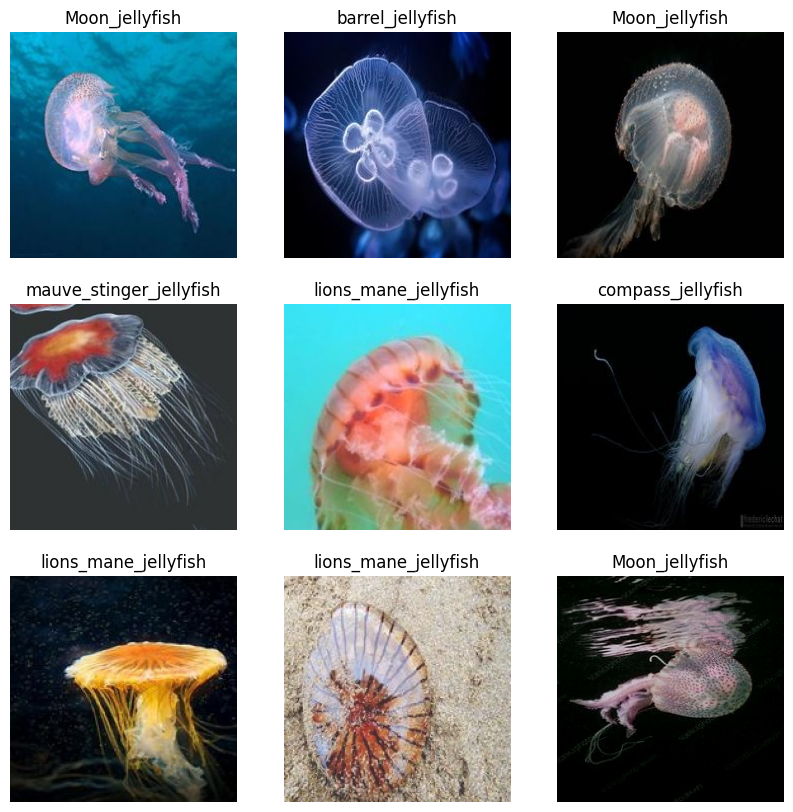

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    root="./Train_Test_Valid/train/",
)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for ax in axs:
    i = np.random.randint(0, len(train_dataset))
    image, label = train_dataset[i]
    ax.imshow(image)
    ax.set_title(label2classname[label])
    ax.axis("off")

plt.show()

## Разбиение на датасеты и аугментации

In [5]:
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=10),
    v2.RandomResizedCrop(size=(128, 128), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(128, 128), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = torchvision.datasets.ImageFolder(
    root="./Train_Test_Valid/train/",
    transform=train_transforms
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True
)
val_dataset = torchvision.datasets.ImageFolder(
    root="./Train_Test_Valid/valid/",
    transform=test_transforms
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False
)
test_dataset = torchvision.datasets.ImageFolder(
    root="./Train_Test_Valid/test/",
    transform=test_transforms
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False
)

In [6]:
len(train_dataset), len(val_dataset), len(test_dataset)

(900, 39, 40)

# Модель

In [14]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(in_features=2048, out_features=len(classes))

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

# Обучение

In [16]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
epochs = 15

train_acc_history = []
val_acc_history = []
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_preds = []
    train_labels = []
    for batch in tqdm(train_dataloader, desc=f"Train {epoch+1}/{epochs}"):
        images, labels = batch
        train_labels += labels.tolist()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = loss_function(preds, labels)
        train_preds += preds.argmax(dim=1).detach().cpu().tolist()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_acc = accuracy_score(train_labels, train_preds)
    train_acc_history.append(train_epoch_acc)
    print(f"Epoch {epoch + 1}/{epochs}, train accuracy: {train_epoch_acc:.2f}")

    model.eval()
    val_preds = []
    val_labels = []
    with torch.inference_mode():
        for batch in tqdm(val_dataloader, desc=f"Validation {epoch+1}/{epochs}"):
            images, labels = batch
            val_labels += labels.tolist()
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            val_preds += preds.argmax(dim=1).detach().cpu().tolist()

    val_epoch_acc = accuracy_score(val_labels, val_preds)
    val_acc_history.append(val_epoch_acc)
    print(f"Epoch {epoch + 1}/{epochs}, validation accuracy: {val_epoch_acc:.2f}")
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_weights = model.state_dict()

Train 1/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/15, train accuracy: 0.61


Validation 1/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/15, validation accuracy: 0.54


Train 2/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/15, train accuracy: 0.89


Validation 2/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/15, validation accuracy: 0.51


Train 3/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/15, train accuracy: 0.87


Validation 3/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/15, validation accuracy: 0.69


Train 4/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/15, train accuracy: 0.91


Validation 4/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/15, validation accuracy: 0.74


Train 5/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/15, train accuracy: 0.92


Validation 5/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/15, validation accuracy: 0.67


Train 6/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/15, train accuracy: 0.92


Validation 6/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/15, validation accuracy: 0.77


Train 7/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/15, train accuracy: 0.94


Validation 7/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/15, validation accuracy: 0.74


Train 8/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/15, train accuracy: 0.95


Validation 8/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/15, validation accuracy: 0.72


Train 9/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/15, train accuracy: 0.94


Validation 9/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/15, validation accuracy: 0.59


Train 10/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/15, train accuracy: 0.95


Validation 10/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/15, validation accuracy: 0.67


Train 11/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/15, train accuracy: 0.94


Validation 11/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/15, validation accuracy: 0.72


Train 12/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/15, train accuracy: 0.96


Validation 12/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/15, validation accuracy: 0.77


Train 13/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/15, train accuracy: 0.95


Validation 13/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/15, validation accuracy: 0.72


Train 14/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/15, train accuracy: 0.95


Validation 14/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/15, validation accuracy: 0.69


Train 15/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/15, train accuracy: 0.96


Validation 15/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/15, validation accuracy: 0.67


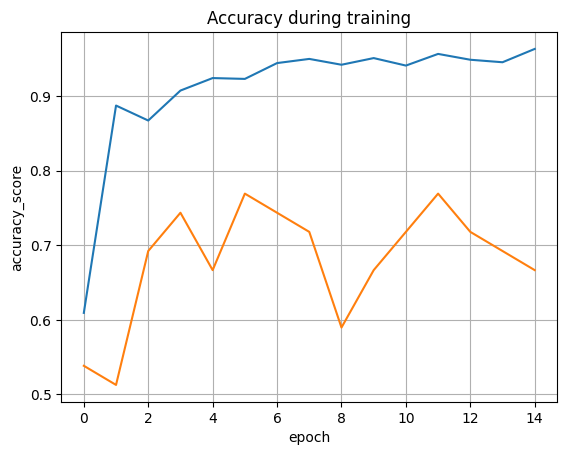

In [17]:
plt.figure()
plt.title("Accuracy during training")
plt.plot(range(epochs), train_acc_history, label="train")
plt.plot(range(epochs), val_acc_history, label="val")
plt.ylabel("accuracy_score")
plt.xlabel("epoch")
plt.grid()
plt.show()

In [18]:
model.load_state_dict(best_weights);

# Проверка на тесте

In [20]:
model.eval()
test_preds = []
test_labels = []
with torch.inference_mode():
    for batch in test_dataloader:
        images, labels = batch
        test_labels += labels.tolist()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        test_preds += preds.argmax(dim=1).detach().cpu().tolist()

test_acc = accuracy_score(test_labels, test_preds)
test_acc

0.875

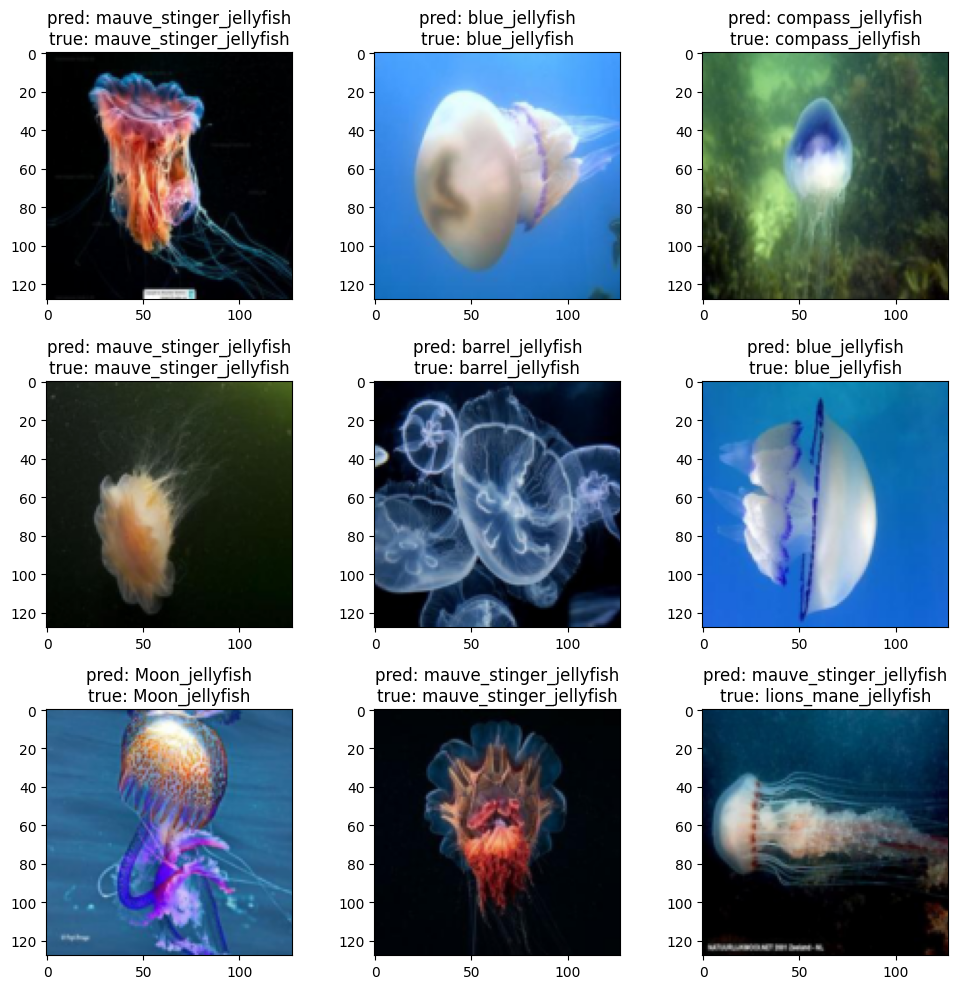

In [37]:
def torch_image_to_numpy(img, MEAN=[0.485, 0.456, 0.406], STD=[0.229, 0.224, 0.225]):
    if img.ndim == 4:
        img = img[0]
    img = img * torch.tensor(STD).view(3, 1, 1) + torch.tensor(MEAN).view(3, 1, 1)
    img = img.permute(1, 2, 0) * 255
    return img.numpy().astype(np.uint8)


idxs = np.random.choice(range(len(test_dataset)), size=9)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for idx, ax in zip(idxs, axs):
    img, label = test_dataset[idx]
    ax.imshow(torch_image_to_numpy(img))
    pred_label = label2classname[test_preds[idx]]
    ax.set_title(f"pred: {pred_label}\ntrue: {label2classname[label]}")

plt.tight_layout()

# Выводы

-   Использована предобученная ResNet50
-   Fine-tuning в течение 15 эпох
-   Accuracy на тесте 0.875